In [12]:
%load_ext autoreload
%aimport lib
%aimport constants
%autoreload 1

import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from lib import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
dataset = load("IV")
# ACHTUNG
# FUCKING WITH THE DATA AHEAD
# YOU HAVE BEEN WARNED
dataset = [dataset[0]] + dataset[4:]

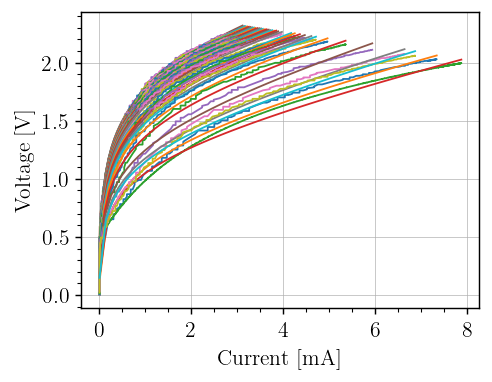

In [14]:
all_params = np.zeros((len(dataset), 3))

for i, data in enumerate(dataset):
    plot_IV(data)
    params, cov = sc.optimize.curve_fit(lambda I, I_s, n, R : curve_IV(I, data.temperature, I_s, n, R), 
                                        data.I, data.V,
                                        p0=(1,1,1),
                                        bounds=(0, np.inf)
                                        )
    all_params[i] = params
    x = np.linspace(data.I.min(), data.I.max())
    plt.plot(x, curve_IV(x, data.temperature, *params))                                 
    

In [15]:
temperatures = np.array([data.temperature for data in dataset])

Text(0, 0.5, '$q \\phi_b$ [eV]')

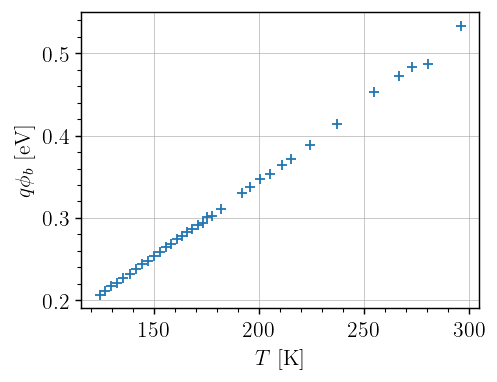

In [16]:
# Find phi_b
# I_S = A * A_G * T² * e^(-q phi_b / kT)
# => phi_b = -kT / q * ln(I_S / (T² A A_G))

I_s = all_params[:, 0]
phi_b_times_q = -sc.constants.k * temperatures * np.log(I_s / (A * A_G * temperatures**2))  # J
phi_b_times_q *= EV_PER_JOULE

plt.scatter(temperatures, phi_b_times_q)
plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$q \phi_b$ [eV]")
# So it's linear in temperature kinda

Text(0, 0.5, '$n$')

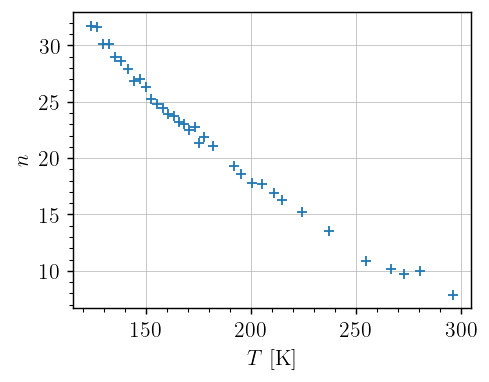

In [17]:
# Plot ideality
n = all_params[:, 1]
plt.scatter(temperatures, n)
plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$n$")

Text(0, 0.5, '$R$ [$\\Omega$]')

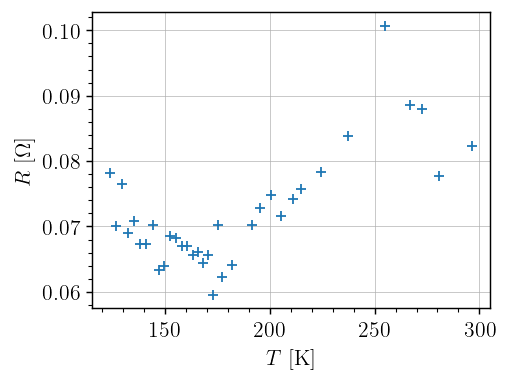

In [18]:
# Plot resistance
R = all_params[:, 2]
plt.scatter(temperatures, R)
plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$R$ [$\Omega$]")

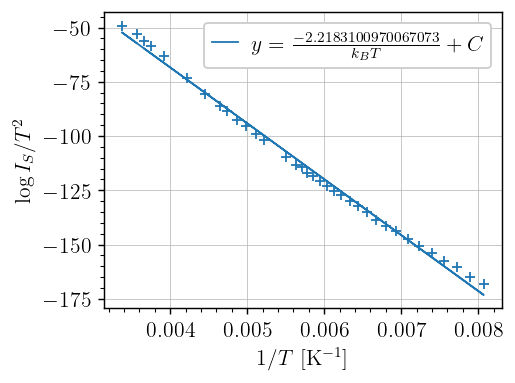

In [ ]:
# Try extracting phi_b the other way [notice uuuuhhhh]
y = np.log(I_s) - 2 * np.log(temperatures)
x = 1 / temperatures

coefs, cov = np.polyfit(x, y, 1, cov=True)
fitfunc = np.poly1d(coefs)
q_phi_b_over_kb = coefs[0]
phi_b_times_q_bis = q_phi_b_over_kb * sc.constants.k * EV_PER_JOULE

plt.scatter(x, y)
plt.plot(x, fitfunc(x), label=fr"$y = \frac{{{phi_b_times_q_bis}}}{{k_B T}} + C$")
plt.xlabel(r"$1/T$ [K$^{-1}$]")
plt.ylabel(r"$\log{I_S / T^2}$")
plt.legend()

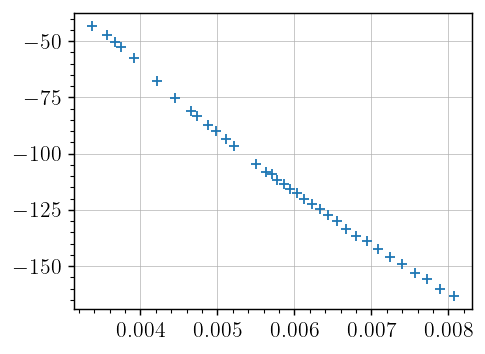

In [20]:
# Alternative way [rapport 2018]
y = n * np.log(all_params[:, 0]) - np.log(temperatures)
x = 1 / temperatures
plt.scatter(x, y)